<a href="https://colab.research.google.com/github/krithika162003/Food-Calorie-Analytics/blob/main/efficientnetb3model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
import os
import zipfile
import pandas as pd

# Specify the path to the ZIP file
zip_file_path = "/content/drive/MyDrive/archive.zip"
# Specify the directory where you want to extract the contents
extracted_dir_path = "D:\downloads\food_extracted"

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# Generate data paths with labels
filepaths = []
labels = []

# Iterate through the extracted directories
for root, dirs, files in os.walk(extracted_dir_path):
    for f in files:
        # Get the full file path
        fpath = os.path.join(root, f)
        filepaths.append(fpath)

        # Determine the label based on the parent directory name
        label = os.path.basename(root)
        labels.append(label)

# Concatenate data paths with labels into one DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Optionally, you can clean up the extracted directory after you're done processing
# Note: Be cautious with this step, as it deletes the extracted files
# import shutil
# shutil.rmtree(extracted_dir_path)


In [ ]:
# Splitting the original DataFrame into training and dummy sets without stratification
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123)

# Splitting the dummy DataFrame into validation and test sets without stratification
valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123)

In [ ]:
# crobed image size
batch_size =64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = val_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4663 validated image filenames belonging to 20 classes.
Found 584 validated image filenames belonging to 20 classes.
Found 584 validated image filenames belonging to 20 classes.


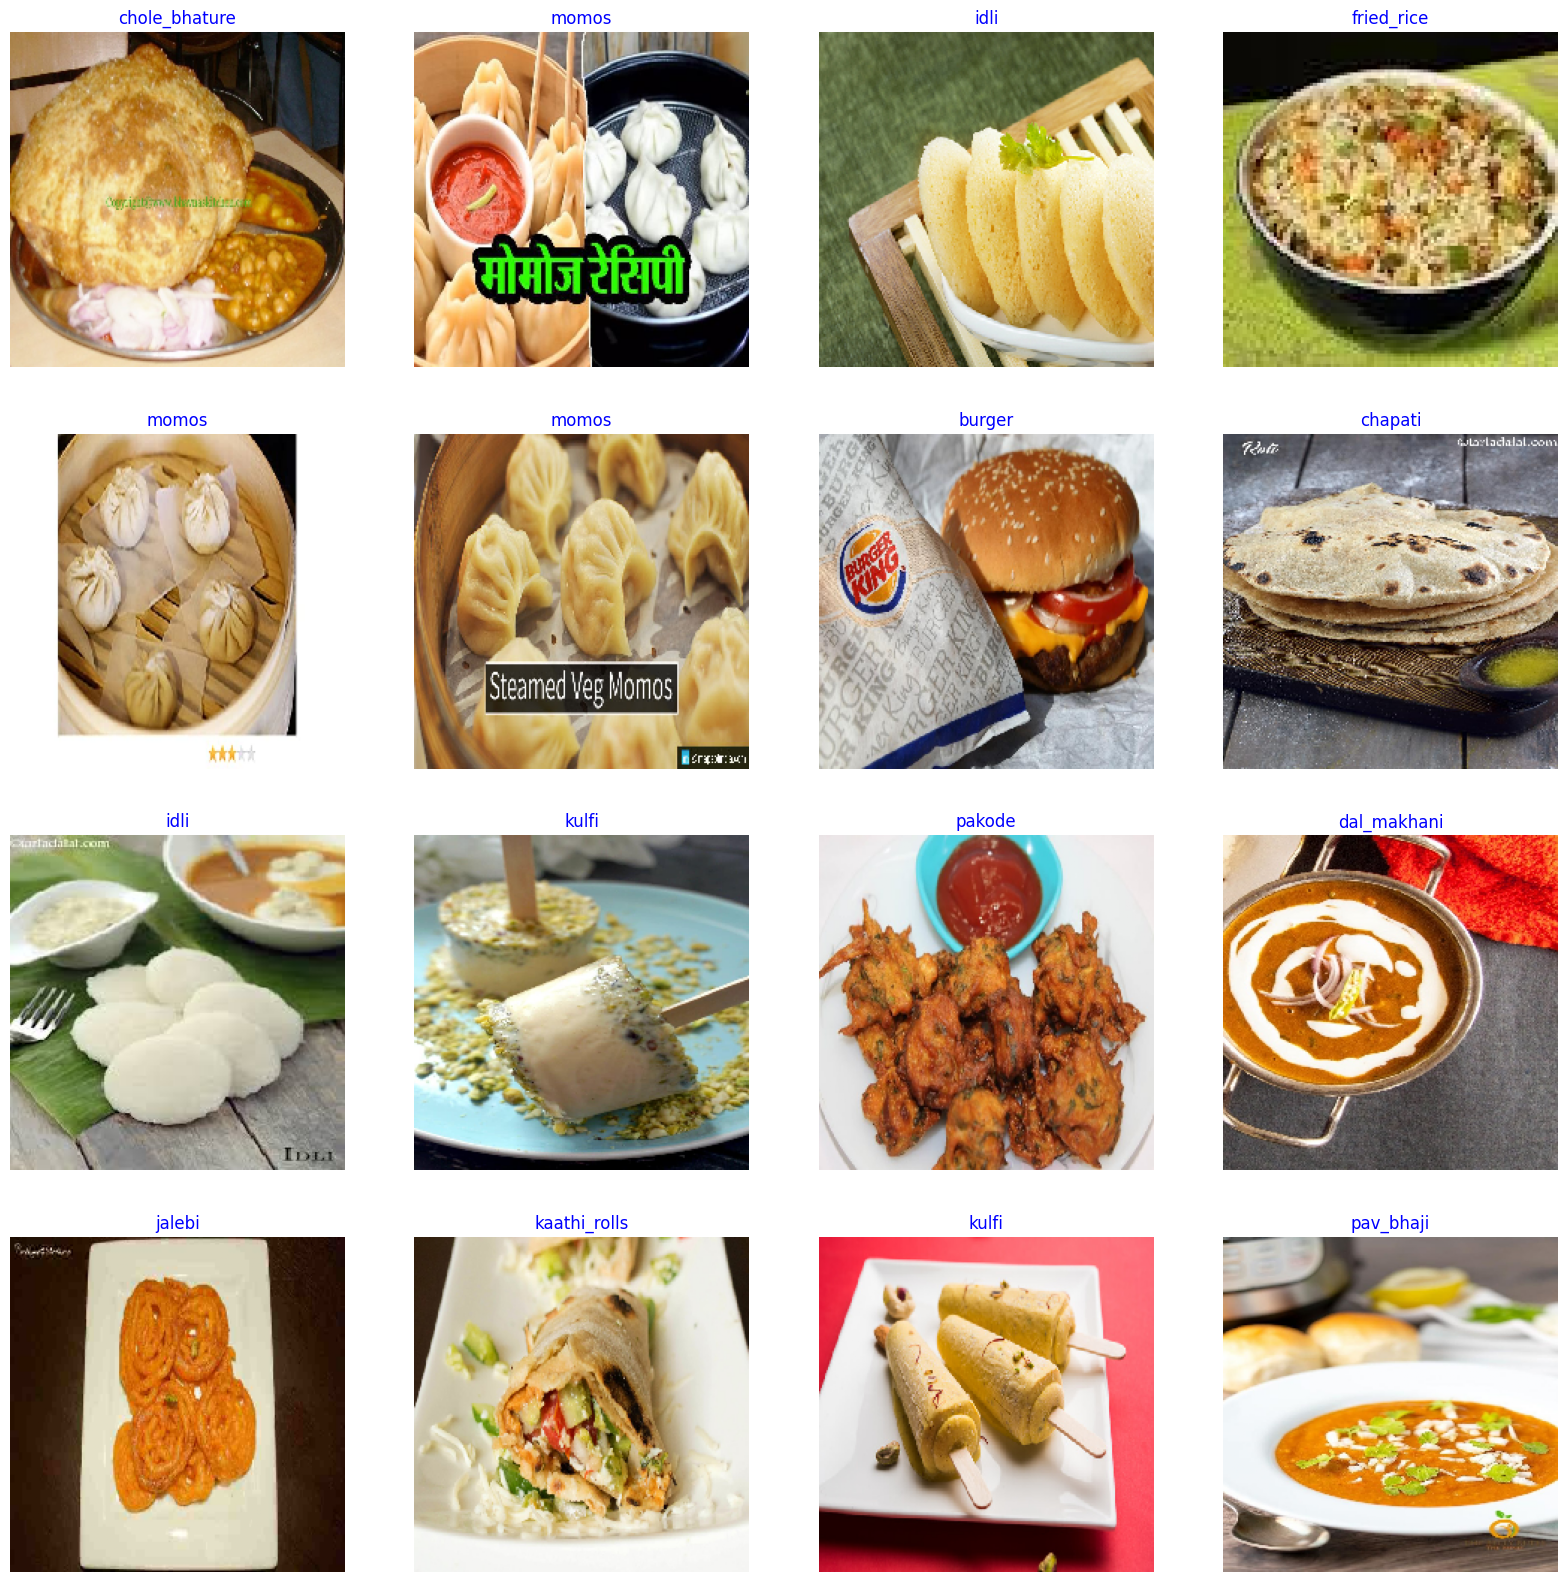

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
# base_model.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 20)                5140      
                                                         

In [ ]:
epochs = 50  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/50
73/73 [==============================] - 161s 1s/step - loss: 8.4330 - accuracy: 0.6144 - val_loss: 7.1933 - val_accuracy: 0.7534
Epoch 2/50
17/73 [=====>........................] - ETA: 58s - loss: 6.4641 - accuracy: 0.8906

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/sequential/efficientnetb3/block2a_expand_bn/FusedBatchNormGradV3 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-7-95b65465f36a>", line 3, in <cell line: 3>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[64,144,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential/efficientnetb3/block2a_expand_bn/FusedBatchNormGradV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_48084]

c


In [ ]:
# Train the model
epochs = 50
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    validation_data=test_gen,
    validation_steps=None,
    shuffle=False
)

Epoch 1/50
73/73 [==============================] - 91s 1s/step - loss: 8.5121 - accuracy: 0.5767 - val_loss: 6.9726 - val_accuracy: 0.8356
Epoch 2/50
73/73 [==============================] - 77s 1s/step - loss: 6.3728 - accuracy: 0.7982 - val_loss: 5.5281 - val_accuracy: 0.9041
Epoch 3/50
73/73 [==============================] - 76s 1s/step - loss: 5.1123 - accuracy: 0.8643 - val_loss: 4.4864 - val_accuracy: 0.9041
Epoch 4/50
73/73 [==============================] - 77s 1s/step - loss: 4.1378 - accuracy: 0.8908 - val_loss: 3.6611 - val_accuracy: 0.9195
Epoch 5/50
73/73 [==============================] - 73s 997ms/step - loss: 3.3475 - accuracy: 0.9198 - val_loss: 3.0023 - val_accuracy: 0.9247
Epoch 6/50
73/73 [==============================] - 78s 1s/step - loss: 2.7347 - accuracy: 0.9312 - val_loss: 2.4739 - val_accuracy: 0.9315
Epoch 7/50
73/73 [==============================] - 74s 1s/step - loss: 2.2613 - accuracy: 0.9367 - val_loss: 2.0625 - val_accuracy: 0.9298
Epoch 8/50
73/73 

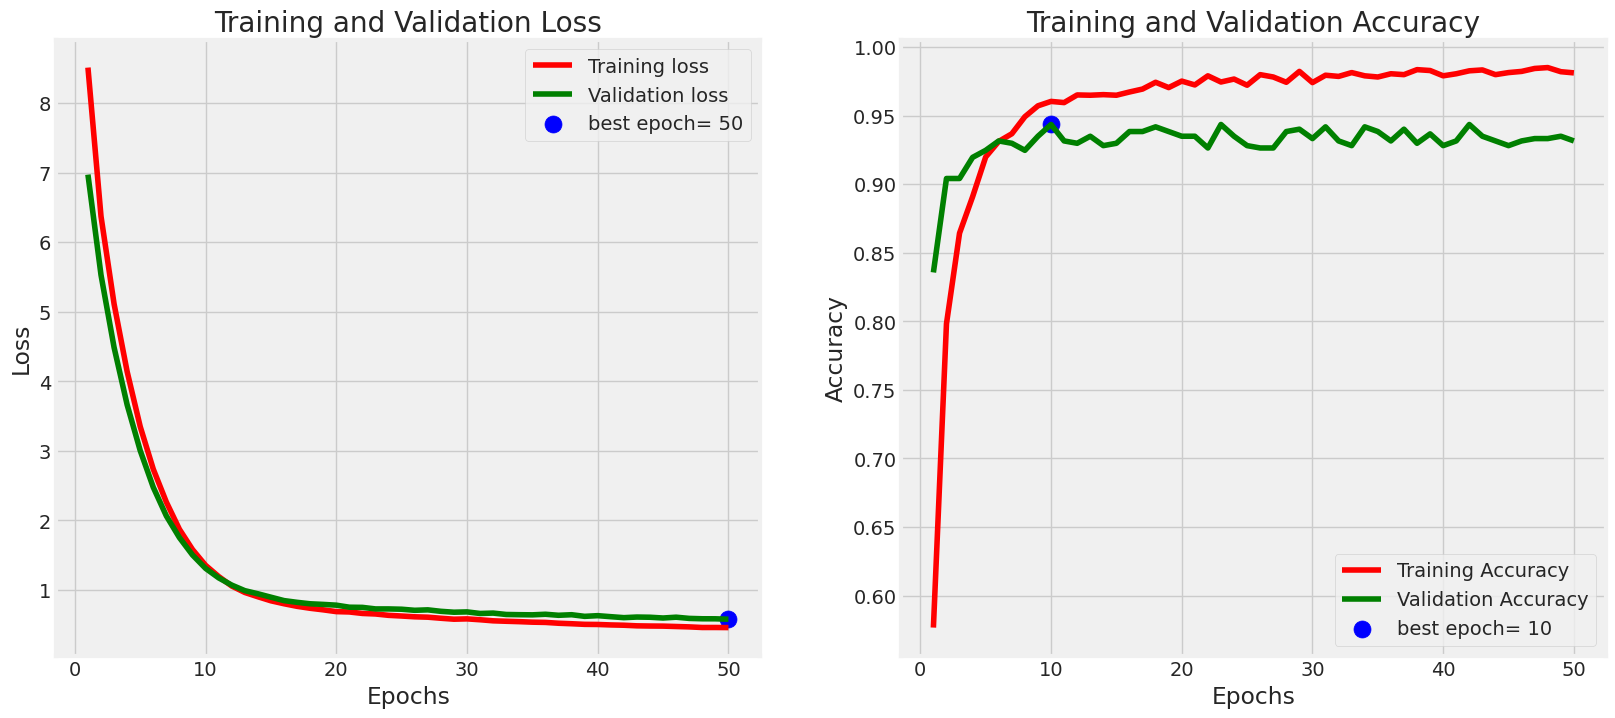

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

8/8 [==============================] - 8s 1s/step - loss: 0.5858 - accuracy: 0.9297
Train Loss:  0.362189382314682
Train Accuracy:  1.0
--------------------
Valid Loss:  0.6514332294464111
Valid Accuracy:  0.900390625
--------------------
Test Loss:  0.5858357548713684
Test Accuracy:  0.9296875


In [ ]:
#Get Predictions
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

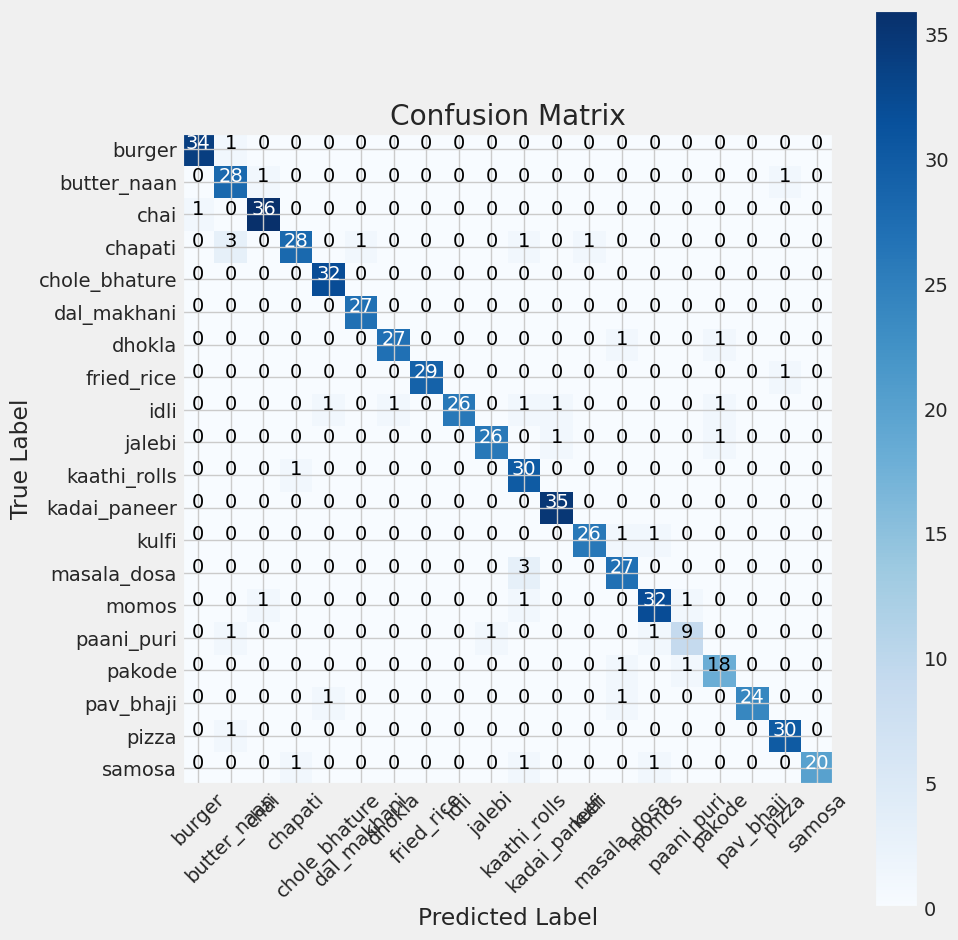

In [ ]:
#Confusion Matrics and Classification Report
import itertools
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

               precision    recall  f1-score   support

       burger       0.97      0.97      0.97        35
  butter_naan       0.82      0.93      0.87        30
         chai       0.95      0.97      0.96        37
      chapati       0.93      0.82      0.87        34
chole_bhature       0.94      1.00      0.97        32
  dal_makhani       0.96      1.00      0.98        27
       dhokla       0.96      0.93      0.95        29
   fried_rice       1.00      0.97      0.98        30
         idli       1.00      0.84      0.91        31
       jalebi       0.96      0.93      0.95        28
 kaathi_rolls       0.81      0.97      0.88        31
 kadai_paneer       0.95      1.00      0.97        35
        kulfi       0.96      0.93      0.95        28
  masala_dosa       0.87      0.90      0.89        30
        momos       0.91      0.91      0.91        35
   paani_puri       0.82      0.75      0.78        12
       pakode       0.86      0.90      0.88        20
    pav_b

In [ ]:
#Save the model
model.save('/content/drive/MyDrive/food_classification.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/food_classification.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
image_path = '/content/download (6).jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 9s 9s/step
momos


In [ ]:
predictions

array([[1.3714771e-05, 5.5734172e-06, 3.5611254e-05, 2.5484037e-06,
        6.0559714e-06, 5.9734589e-06, 4.1564249e-06, 1.6159054e-05,
        2.0860321e-05, 1.3261624e-05, 2.1195430e-05, 3.9590368e-06,
        1.7678600e-05, 3.4430118e-06, 9.9969351e-01, 1.6459830e-05,
        3.0950687e-05, 3.7781281e-06, 2.3651585e-06, 8.2948420e-05]],
      dtype=float32)

In [ ]:
image_path = '/content/download (15).jpg'
image = Image.open(image_path)

# Preprocess the image
img = image.resize((224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Make predictions
predictions = loaded_model.predict(img_array)
class_labels = classes
score = tf.nn.softmax(predictions[0])
print(f"{class_labels[tf.argmax(score)]}")

1/1 [==============================] - 0s 83ms/step
butter_naan


In [ ]:
predictions

array([[3.4358731e-05, 9.7960544e-01, 2.2705273e-05, 1.8554866e-02,
        6.4463064e-05, 7.0103299e-05, 8.2989100e-05, 4.4695669e-05,
        1.3972001e-04, 3.0523930e-05, 7.4809628e-05, 2.6175453e-04,
        2.6225325e-04, 9.0927686e-05, 6.2761021e-05, 4.3604246e-05,
        2.2888677e-05, 7.5725613e-05, 4.3193638e-04, 2.3605404e-05]],
      dtype=float32)